Sources
--
- https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models
- The book: Hand on Machine Learning with sklearn and Tensorflow by Aurélien Géron
- helper functions for building the custom CNN from https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
- complex CNN architecture from https://www.kaggle.com/shawon10/plant-pathology-eda-and-deep-cnn

Imports
--

In [ ]:
%matplotlib inline

import cv2
import random
import time
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

tqdm.pandas() # for using pandas.Series.progress_apply()
import plotly.express as px
import plotly.figure_factory as ff # for the distplot
import plotly.graph_objects as go # for the box plot without named columns

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization,Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from IPython.display import display

tf.compat.v1.disable_eager_execution() # necessary since the last tf update

In [ ]:
tf.__version__

Run this command to reset the computational graph when rerunning the notebook.

In [ ]:
tf.compat.v1.reset_default_graph()

Workflow
--

1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights
4. Prepare the data for machine learning algorithms
5. Select a model and train it
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system. 

# 1. Look at the big picture

(Competition explanation from Kaggle)
Problem Statement
--
Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.

Specific Objectives
--
Objectives of ‘Plant Pathology Challenge’ are to train a model using images of training dataset to 1) Accurately classify a given image from testing dataset into different diseased category or a healthy leaf; 2) Accurately distinguish between many diseases, sometimes more than one on a single leaf; 3) Deal with rare classes and novel symptoms; 4) Address depth perception—angle, light, shade, physiological age of the leaf; and 5) Incorporate expert knowledge in identification, annotation, quantification, and guiding computer vision to search for relevant features during learning.

# 2. Get the data

In [ ]:
# Use this method to walk through a directory and display all the contents

#import os
#for dirname, _, filenames in os.walk('../input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [ ]:
path = '../input/plant-pathology-2020-fgvc7/'
SAMPLE_LEN = 100
IMG_PATH = path + 'images/'

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
sample_sub = pd.read_csv(path + 'sample_submission.csv')

In [ ]:
display(df_train.head())
display(df_test.head())
display(sample_sub.head())

print('df_train shape: ', df_train.shape)
print('df_test shape: ', df_test.shape)

In [ ]:
def load_image(image_id):
    file_path = image_id + ".jpg"
    img = cv2.imread(IMG_PATH + file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

train_images = df_train["image_id"][:SAMPLE_LEN].progress_apply(load_image)

# Discover and visualize the data to gain insights

In [ ]:
fig = px.imshow(cv2.resize(train_images[0], (205, 136)))
fig.show()

Observation: 
- While green parts of the image show low blue values (on the RGB scale) the brown parts show high blue values. This suggest that the blue channel may be important to detect diseases on leaves.

## Channel Distributions

In [ ]:
red_values = [np.mean(train_images[idx][:, :, 0]) for idx in range(len(train_images))]
green_values = [np.mean(train_images[idx][:, :, 1]) for idx in range(len(train_images))]
blue_values = [np.mean(train_images[idx][:, :, 2]) for idx in range(len(train_images))]
values = [np.mean(train_images[idx]) for idx in range(len(train_images))]

### with matplotlib.pyplot

In [ ]:
plt.figure(figsize=[16, 14])

plt.subplot(411)
sns.distplot(values, hist=True, rug=True, bins=50, color='grey')
plt.title('Distribution of channel values.')

plt.subplot(412)
sns.distplot(red_values, hist=True, rug=True, bins=50, color='red')
plt.title('Distribution of red channel values.')

plt.subplot(413)
sns.distplot(green_values, hist=True, rug=True, bins=50, color='green')
plt.title('Distribution of green channel values.')

plt.subplot(414)
sns.distplot(blue_values, hist=True, rug=True, bins=50, color='blue')
plt.title('Distribution of blue channel values.');

Observations:
- The distribution of the values of the combined channels resemble a normal distribution centered around 105.
- The distribution of the red channel values also show a normal distribution which is a little tail heavy (rightward skew).
- The green channel shows a more uniform like distribution of values with a smaller peak and a leftward skew.
- The blue channel has the most uniform distribution.

In [ ]:
comb = [red_values, green_values, blue_values]

fig = plt.figure(figsize=[8, 6])
plt.boxplot(comb, labels=['Red', 'Green', 'Blue'])
plt.title('Boxplots for different color channels')
plt.ylabel('Color value')
plt.xlabel('Color channel');

### with plotly.figure_factory

#### individual plots

In [ ]:
fig_all = ff.create_distplot([values], group_labels=["All Channels"], colors=["purple"])
fig_all.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig_all.data[0].marker.line.width = 0.5
display(fig_all)

fig_r = ff.create_distplot([red_values], group_labels=["Red Channel"], colors=["red"])
fig_r.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig_r.data[0].marker.line.width = 0.5
display(fig_r)

fig_g = ff.create_distplot([green_values], group_labels=["Green Channel"], colors=["green"])
fig_g.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig_g.data[0].marker.line.width = 0.5
display(fig_g)

fig_b = ff.create_distplot([blue_values], group_labels=["Blue Channel"], colors=["blue"])
fig_b.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig_b.data[0].marker.line.width = 0.5
display(fig_b)

#### combined plots

In [ ]:
fig = ff.create_distplot([red_values, green_values, blue_values], 
                         group_labels=['Red Channel', 'Green Channel', 'Blue Channel'], 
                         colors=['red', 'green', 'blue'])

fig.update_layout(title_text='Distribution of all channel values')
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5

fig

Observations:
- When plotting all three color channel distributions in one plot the distribution curves look very similar. Green has the highest values, followed by red and blue.

Using plotly.graph_objects.Figure().add_trave create a boxplot from image data (which is not represented in a pandas DataFrame with column names).

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=red_values, name="Red Channel", marker_color='red'))
fig.add_trace(go.Box(y=green_values, name="Green Channel", marker_color='green'))
fig.add_trace(go.Box(y=blue_values, name="Blue Channel", marker_color='blue'))
fig.update_layout(yaxis_title="RGB value", xaxis_title="Color channel",
                  title="RGB value vs. Color channel")

## Visualize different leafs

In [ ]:
# Notice: df_train is cut off at SAMPLE_LEN

def plot_sample_leafs(symp, rows=2, cols=3):
    
    last_row_cols = None
    
    # get indexes of images with specified symptom
    df = df_train.iloc[:SAMPLE_LEN, :]
    indexes = df.index[df[symp] == 1].tolist()
    
    # check if the df contains rows*cols number of images with specified symptom
    if len(indexes) >= rows*cols:
        sample_indexes = random.sample(indexes, rows*cols)
    else:
        sample_indexes = indexes
        # check if the indexes can be divided into full rows
        if len(indexes)%cols == 0:
            rows = int(len(indexes)/cols)
        # otherwise define the number of pictures in the last row
        else:
            rows = int(len(indexes)/cols) + 1
            last_row_cols = len(indexes)%cols
            
    # create axes
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, (20/3)*rows))
    
    # show images
    for r in range(rows):
        for c in range(cols):
            sample_index = sample_indexes.pop()
            ax[r, c].imshow(cv2.resize(train_images[sample_index], (205, 136)))
            
            # break the loop if no more axes can be filled with images
            if last_row_cols is not None and (r==rows-1 and c==last_row_cols-1):
                print('Not enough images with specified symp to fill all axis.')
                break
            
    plt.show()

In [ ]:
plot_sample_leafs('healthy')

In [ ]:
plot_sample_leafs('scab')

In [ ]:
plot_sample_leafs('rust')

In [ ]:
plot_sample_leafs('multiple_diseases')

Observations:
- Healthy leafs show green color across the entire leafs.
- Leafs with scab have large stretches of brown across the leaf. Scab is defined as "any of various plant diseases caused by fungi or bacteria and resulting in crustlike spots on fruit, leaves, or roots".
- Leafs with rust show smaller yellow to reddish spots. Rust is defined as "a disease, especially of cereals and other grasses, characterized by rust-colored pustules of spores on the affected leaf blades and sheaths and caused by any of several rust fungi".
- Leafs with multiple diseases show symptoms of scab and rust with especially reddish spots.

## Visualizations of target variables

In [ ]:
fig = px.parallel_categories(df_train[["healthy", "scab", "rust", "multiple_diseases"]], 
                             color="healthy", color_continuous_scale="sunset",
                             title="Parallel categories plot of targets")
fig

Observations:
- The data is labelled so that only ever one symptom is true for every sample (e.g. either 'healthy', 'scab', 'rust' or 'multiple_diseases').

In [ ]:
fig = go.Figure([go.Pie(labels=df_train.columns[1:],
           values=df_train.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Pie chart of targets", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

Observations:
- A majority of leafs in the dataset are unhealthy and show either symptoms of scab or rust. Only very few images show multiple diseases.

### Distributions of target variables

In [ ]:
def plotly_hist(df, col, title, is_wanted=True):
    true_color = 'green'
    false_color = 'red'
    if is_wanted is not True:
        true_color = 'red'
        false_color = 'green'
    df = df[col].apply(bool).apply(str)
    fig = px.histogram(df, x=col, title=title, color=col, color_discrete_map={
                                                                    'True': true_color,
                                                                    'False': false_color})
    fig.update_layout(template="simple_white")
    fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
    fig.data[0].marker.line.width = 0.5
    fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
    fig.data[1].marker.line.width = 0.5
    display(fig)
    
plotly_hist(df_train, 'healthy', 'Healthy distribution')
plotly_hist(df_train, 'scab', 'Scab distribution', is_wanted=False)
plotly_hist(df_train, 'rust', 'Rust distribution', is_wanted=False)
plotly_hist(df_train, 'multiple_diseases', 'Multiple diseases distribution', is_wanted=False)

# 4. Prepare the data for machine learning algorithms

## Introduction to image processing techniques with OpenCV

### Canny edge detection

The Process of Canny edge detection algorithm can be broken down to 5 different steps (Wikipedia):

1. Apply Gaussian filter to smooth the image in order to remove the noise
2. Find the intensity gradients of the image
3. Apply non-maximum suppression to get rid of spurious response to edge detection
4. Apply double threshold to determine potential edges
5. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

Good explanation of individual steps on https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html.

cv2.Canny(image, minVal, maxVal) returns a binary image with the highlighted edges.

In [ ]:
# This method processes the canny edges for a given image and calculates the bounding box of the object
# from the part of the image which contains edge pixels.
# Using Canny edge detection to identify a bounding box works well for images with a blurred background.
def show_edges_and_bounding_box(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

In [ ]:
show_edges_and_bounding_box(train_images[0])
show_edges_and_bounding_box(train_images[1])
show_edges_and_bounding_box(train_images[2])

### Flipping

Flipping is a useful method in data augmentation. Because a flipped image looks entirely different to a computer algorithm, it helps increasing the amount of training images. Even with lots of data, augmentation of this data can make it more robust, for example by flipping certain areas of images which only ever pointed in one direction. This could have been a false feature the algorithm would have picked up on.

cv2.flip(src, flipCode[, dst]) returns the flipped array (here image) dst.
Parameters:	
- src – input array.
- dst – output array of the same size and type as src. If dst is specified the function will return None.
- flipCode – a flag to specify how to flip the array; 0 means flipping around the x-axis and positive value (for example, 1) means flipping around y-axis. Negative value (for example, -1) means flipping around both axes.

In [ ]:
def show_flips(img):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(cv2.flip(img, 0))
    ax[1].set_title('Vertical Flip', fontsize=24)
    ax[2].imshow(cv2.flip(img, 1))
    ax[2].set_title('Horizontal Flip', fontsize=24)
    plt.show()

In [ ]:
show_flips(train_images[0])
show_flips(train_images[1])
show_flips(train_images[2])

### Blurring

Over-fitting usually happens when your neural network tries to learn high frequency features (patterns that occur a lot) that may not be useful. Gaussian noise, which has zero mean, essentially has data points in all frequencies, effectively distorting the high frequency (high level) features. This also means that lower frequency (low level) components (usually, your intended data) are also distorted, but your neural network can learn to look past that. Adding just the right amount of noise can enhance the learning capability.

cv2.blur() method is used to blur an image using the normalized box filter (This is NOT gaussian noise). The function smooths an image using the kernel. (https://www.geeksforgeeks.org/python-opencv-cv2-blur-method/)

dst	= cv.blur(src, ksize[, dst[, anchor[, borderType]]])

Parameters:
- src: Input array/ image
- ksize: tuple with the size of the kernel used for the blurring algorithm

In [ ]:
def show_blurred_image(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(cv2.blur(img, (100, 100)))
    ax[1].set_title('Blurred Image', fontsize=24)
    plt.show()

In [ ]:
show_blurred_image(train_images[0])

## Introduction to essential layers of convolutional neural networks (CNNs)

### Convolution

The convolution algorithm transformes an input image of a certain shape into an output image with a certain shape by moving filters/kernels/weights across the input image and calculating the weighed sums (dot product of filter values and image values). 

Here the ouput image is smaller than the input image after the convolution.

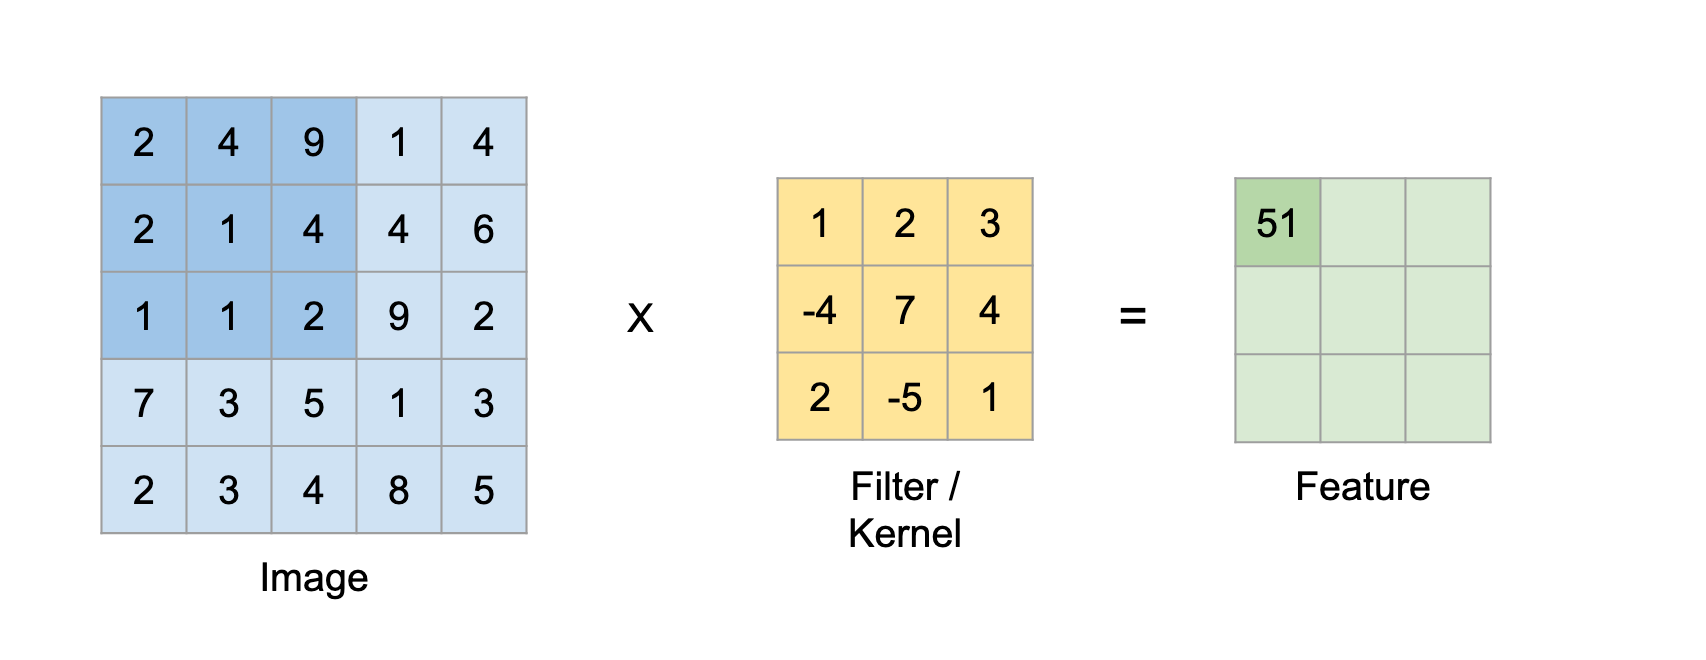

The output image can also be of the same shape as the input image or larger by adding a zero padding around the outside of the input image.

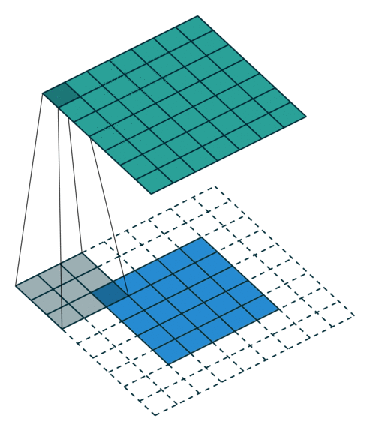

OpenCV has a builtin function cv2.filter2D() to convolve a kernel with an image. It’s arguments are

- src: input image
- ddepth: desired depth of the output image. If it is negative, it will be the same as that of the input image (-> adds zero padding).
- borderType: pixel extrapolation method.

(https://theailearner.com/tag/cv2-filter2d/)

In [ ]:
# this method visualizes the effect of a convolution with a 7x7 filter where every value is 1/25

def show_conv(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    kernel = np.ones((7, 7), np.float32)/25
    conv = cv2.filter2D(img, -1, kernel) # ddepth=-1 ensure output.shape is equal to input.shape
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(conv)
    ax[1].set_title('Convolved Image', fontsize=24)
    plt.show()

In [ ]:
show_conv(train_images[0])

In this case the filter used was specified to be a 7x7 array with all values equal to 1/25.
Because the filter values are multiplied with the image RGB values, increasing the filter values will brighten the output image up to a point where it becomes all white, when (r,g,b)=(255,255,255). And decreasing the filter values will darken the output image. Of course in this case the filter is uniformly filled with values. In an actual convolutional layer of a CNN the filters are generated so that they highlight certain (informative) aspect of the image. 

However using such filters for convolution can again be used for augmenting image data.

It seems like this filter has a 'increasing sunshine' effect on the image.

### Max Pooling

Max pooling is very similar to convolution, except it involves finding the maximum value in a window instead of finding the dot product of the window with a kernel. Max pooling does not require a kernel and it is very useful in reducing the dimensionality of convolutional feature maps in CNNs. The image below demonstrates the working of MaxPool:

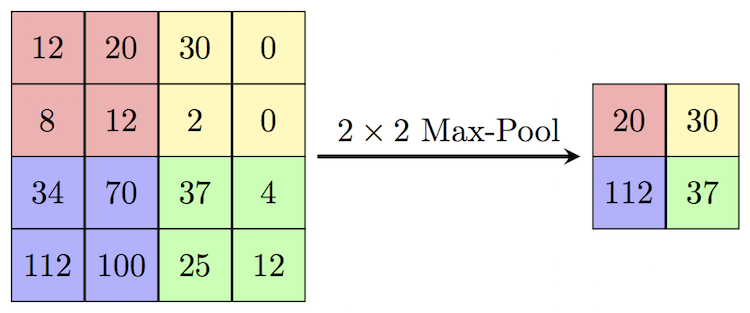

### ReLu

ReLU stands for rectified linear unit, and is a type of activation function. Mathematically, it is defined as y = max(0, x). Visually, it looks like the following:
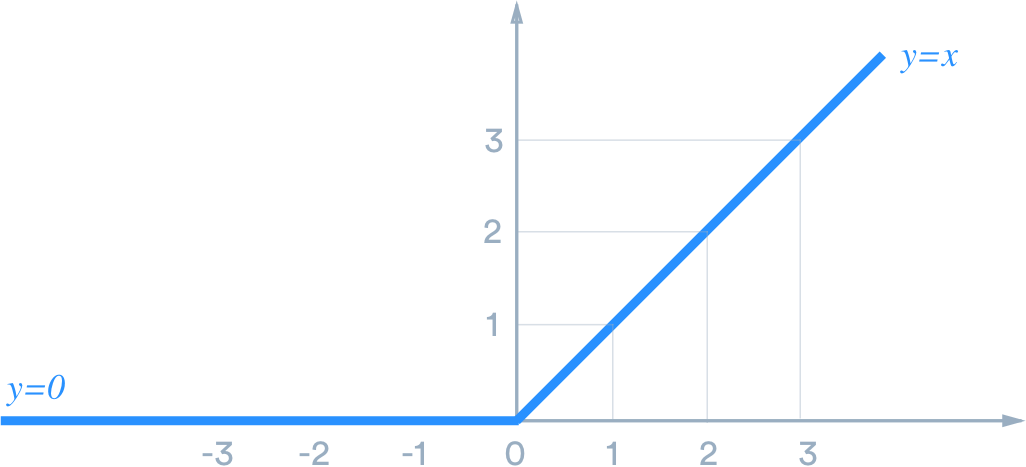

Read here about different types of ReLUs: https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

Read here about why ReLUs work: https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning

## Create training and validation subsets

In [ ]:
# Number of classes
num_classes = 4

# Number of colour channels for the images
num_channels = 3

# Tuple with height and width and channels of images used to reshape arrays.
img_shape = train_images[0].shape

print('img_shape: ', img_shape, '\n'
     'img_width: ', train_images[0].shape[1], '\n'
     'img_height: ', train_images[0].shape[0], '\n'
     'num_classes: ', num_classes, '\n'
     'num_channels: ', num_channels)

The images are very large right now. Resize them to shape(256, 256) to save on memory. If I do not resize the images I run into an out-of-RAM-issue lateron.

In [ ]:
img_width = 128
img_height = 128
img_shape = (img_height, img_width, num_channels)

# TensorFlow functions require numpy arrays
labels = df_train.drop('image_id', axis=1).to_numpy()

image_ids = df_train['image_id'].to_numpy()

# encode as 
# healthy = 0
# multiple_diseases = 1
# rust = 2
# scab = 3
labels_cls = df_train['healthy']*1 + df_train['multiple_diseases']*2 + df_train['rust']*3 + df_train['scab']*4 - 1 

# set to 0 to train on all available data
VALIDATION_SIZE = 181

# split data into training & validation
# we do not specify x_train here because the images will be loaded in by batch lateron so save memory
#### DELETE x_test = train_images[:VALIDATION_SIZE]
y_test = labels[:VALIDATION_SIZE]
test_ids = image_ids[:VALIDATION_SIZE]
# keep a single target vector for print_test_accuracy() function
y_test_cls = labels_cls[:VALIDATION_SIZE]

###### DELETE x_train = train_images[VALIDATION_SIZE:]
y_train = labels[VALIDATION_SIZE:]
train_ids = image_ids[VALIDATION_SIZE:]
y_train_cls = labels_cls[VALIDATION_SIZE:]


print('train ids shape: {}'.format(train_ids.shape))
print('validation ids shape: {}'.format(test_ids.shape))

# 5. Select a model and train it - Build custom CNN

## Building the computational graph (layering the CNN) 

### defining helper functions

In [ ]:
def new_weights(shape):
    return tf.Variable(tf.random.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filters=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(input=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### CNN configuration

In [ ]:
# Convolutional Layer 1.
filter_size1 = 8          # Convolution filters are 8x8 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 8          # Convolution filters are 8x8 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Convolutional Layer 3.
filter_size3 = 4
num_filters3 = 72

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

### placeholder variables

In [ ]:
x = tf.compat.v1.placeholder(tf.float32, shape=[None, img_height, img_width, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_height, img_width, num_channels])
y_true = tf.compat.v1.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

### layering components

Create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters, each having width and height equal to filter_size1. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [ ]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                           num_input_channels=num_channels,
                                           filter_size=filter_size1,
                                           num_filters=num_filters1,
                                           use_pooling=True)

In [ ]:
layer_conv1

Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [ ]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                           use_pooling=True)

In [ ]:
layer_conv2

Third conolutional layer.

In [ ]:
layer_conv3, weights_conv3 = new_conv_layer(input=layer_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                           use_pooling=True)

In [ ]:
layer_conv3

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [ ]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [ ]:
layer_flat, num_features

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [ ]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [ ]:
layer_fc1

Add another fully-connected layer that outputs vectors of length 4 for determining which of the 4 classes the input image belongs to. Note that ReLU is not used in this layer.

In [ ]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [ ]:
layer_fc2

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [ ]:
y_pred = tf.nn.softmax(layer_fc2)

In [ ]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost function to be optimized

In [ ]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

In [ ]:
cost = tf.reduce_mean(cross_entropy)

### Optimization method

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance measures

In [ ]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow run

### creating helper functions

In [ ]:
def load_image_batch(image_ids, for_tf=True, img_shape=(128, 128)):
    """
    params:
    image_ids: list of image_ids to load from preset path.
    for_tf: boolean signaling wether the ouput will be reshaped to a 4D Tensor or be a list of 3D arrays.
    If reshape=False then the returned list can be used for plotting images.
    Return: 4D Tensor or list of 3D arrays.
    The Output has the shape (image_num, image_height, image_width, num_channels) which is the required
    shape of a Tensor for TensorFlow.
    """
    imgs = []
    for image_id in image_ids:
        file_path = image_id + ".jpg"
        img = cv2.imread(IMG_PATH + file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_shape)
        imgs.append(img)
    
    # reshape output array to 4D Tensor and normalize values
    if for_tf == True:
        image_batch = np.ndarray(shape=(len(imgs), img_shape[0], img_shape[1], 3),dtype = np.float32)
        for i in range(len(imgs)):
            image_batch[i] = imgs[i] / 255.0
    else:
        image_batch = imgs
        
    return image_batch
    

def random_batch(image_ids, y, batch_size):
    
    assert (len(image_ids) == len(y))
    
    random_indexes = np.random.permutation(len(image_ids))
    batch_indexes = random_indexes[:batch_size]
    
    image_ids = image_ids[batch_indexes]
    x_batch = load_image_batch(image_ids)
    y_batch = y[batch_indexes]
    
    return x_batch, y_batch

train_batch_size = 64

# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch(train_ids, y_train, batch_size=train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    if isinstance(images, pd.DataFrame):
        images = images.to_numpy()
        
    if isinstance(cls_true, pd.Series):
        cls_true = cls_true.to_numpy()
        
    if isinstance(cls_pred, pd.Series):
        cls_pred = cls_pred.to_numpy()
            
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i])

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    image_ids = test_ids[incorrect]
    image_ids = image_ids[0:9]
    # pass reshape=False so it returns a list of images instead of a 4D Tensor
    images = load_image_batch(image_ids, for_tf=False) 
    
    ###########images.shape
    ##########plt.imshow(images[0])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect] 
    
    # Plot the first 9 images.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = y_test_cls 
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
# Split the test-set into smaller batches of this size.
test_batch_size = 64

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = test_ids.shape[0]

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        image_ids = test_ids[i:j]
        images = load_image_batch(image_ids)

        # Get the associated labels.
        labels = y_test[i:j]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images, y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = y_test_cls 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    # correct_sum = correct.sum()
    correct_sum = sum(1 for boo in correct if boo == True)

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Creating TensorFlow session

In [ ]:
session = tf.compat.v1.Session()

In [ ]:
session.run(tf.compat.v1.global_variables_initializer())

### Training

#### Performance before any optimization

The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [ ]:
print_test_accuracy()

#### Performance after 1 optimization iteration
The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [ ]:
optimize(num_iterations=1)

In [ ]:
print_test_accuracy()

#### Performance after 100 optimization iterations

After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [ ]:
optimize(num_iterations=99) # We already performed 1 iteration above.

In [ ]:
print_test_accuracy(show_example_errors=True)

#### Performance after 1000 optimization iterations

After 1000 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 90%.

In [ ]:
optimize(num_iterations=900) # We performed 100 iterations above.

In [ ]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

#### Save solution for kaggle

In [ ]:
def get_pred_by_batch(test_ids):
    
    full_pred = np.zeros(shape=(len(test_ids), 4))
    
    num_test = test_ids.shape[0]
    
    # The starting index for the next batch is denoted i.
    i = 0
    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        image_ids = test_ids[i:j]
        images = load_image_batch(image_ids)
        
        # pass to CNN and get predictions
        feed_dict = {x: images}
        pred = session.run(y_pred, feed_dict=feed_dict)
        full_pred[i:j] = pred
        
        i = j
    
    return full_pred

In [ ]:
pred = get_pred_by_batch(df_test['image_id'])
pred = pd.DataFrame(pred, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])

pred = pd.concat([df_test['image_id'], pred], axis=1)

In [ ]:
pred.head()

In [ ]:
pred.to_csv('plant_pathology_2020_sol_1000its', index=False)

# 6. Refine model

Try using a more complex CNN and enlarge dataset with previously mentioned data augmentation techniques.

In [ ]:
tf.compat.v1.reset_default_graph()
tf.compat.v1.enable_eager_execution()

Prepare data.

In [ ]:
img_size = 100

In [ ]:
path = '../input/plant-pathology-2020-fgvc7/'
IMG_PATH = path + 'images/'

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

def fetch_imgs_np(names, img_size=100, num_channels=3, normalize=True):
    imgs_np = np.ndarray(shape=(len(names), img_size, img_size, num_channels), dtype=np.float32)
    for i, name in enumerate(names):
        img_path = IMG_PATH + name + '.jpg'
        img=cv2.imread(img_path)
        img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
        if normalize is True:
            img = img / 255
        imgs_np[i] = img
    return imgs_np
        
train_imgs = fetch_imgs_np(df_train['image_id'], img_size=img_size)
test_imgs = fetch_imgs_np(df_test['image_id'], img_size=img_size)

# label_columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
x_train, x_val, y_train, y_val = train_test_split(train_imgs, df_train.drop('image_id', axis=1), test_size=0.2, random_state=42)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

In [ ]:
def construct_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', input_shape=(img_size, img_size, 3),
                activation='relu'))
    model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
   
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten()) # Flatten the input
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    # Configure the learning process
    # The loss function is the objective that the model will try to minimize
    # For any classification problem, use accuracy metric
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    model.summary()
    return model

In [ ]:
model = construct_model()

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(x_train)

# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
               steps_per_epoch=x_train.shape[0] // 32,
               epochs=120,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(x_val, y_val))

Reduce predicted values from floating point numbers to 0 and 1. With only ever one 1 per row/ sample.

In [ ]:
predict = model.predict(test_imgs)
all_predict = np.ndarray(shape = (test_imgs.shape[0],4),dtype = np.float32)
for i in range(0,test_imgs.shape[0]):
    for j in range(0,4):
        if predict[i][j]==max(predict[i]):
            all_predict[i][j] = 1
        else:
            all_predict[i][j] = 0 

In [ ]:
healthy = [pred[0] for pred in all_predict]
multiple_diseases = [pred[1] for pred in all_predict]
rust = [pred[2] for pred in all_predict]
scab = [pred[3] for pred in all_predict]

df_dict = {'image_id':df_test['image_id'],'healthy':healthy,'multiple_diseases':multiple_diseases,'rust':rust,'scab':scab}
pred = pd.DataFrame(df_dict)

pred.head()

In [ ]:
pred.to_csv('plant_pathology_2020_sub_xCNN', index=False)

# 7. Present solution

Whilst the first algorithm achieved a score around 0.68 on the kaggle test set, the second one got up to 0.84.